# Hands-on Project 2018-2019

## I - Collect Data

### Importation des librairies

In [7]:
import requests
import os
import zipfile
import yaml

### Lecture du fichier YAML (parameters.yaml)

##### Par défaut le fichier YAML télécharge les données de 2015 à 2018.
On définit une fonction de vérification des données chargées

In [16]:
###### Cette fonction vérifie que les années sont correctement indiquées dans le fichier de configuration.######

def verify_years(params):
    
    # On teste si first_year et last_year sont comprises entre 2007 et 2018.
    # Si c'est correct, on renvoie True.
    
    if (2007 <= int(params['first_year']) <= 2018 
        and 2007 <= int(params['last_year']) <= 2018 
        and int(params['first_year']) <= int(params['last_year'])): return True
               
    # Dans le cas contraire, on envoie un message d'erreur
    else:
        print ("Erreur dans le fichier YAML, last_year et/ou first_year n'est pas compris entre 2007 et 2018 ou bien first_year est supérieur à last_year")
        return False

##### Ouverture et chargement des paramètres du fichiel YALM

In [17]:
with open('parameters.yml', 'r') as file: # On ouvre le fichier YAML
    params = yaml.load(file) # On créé un dictionnaire de paramètres à partir des données du fichier YAML


types_files = ['Prix', 'Stations','Services'] # On définit les types de fichiers à télécharger
files_to_dl = [] # On créé une liste vide qui accueillera les noms des fichiers

if verify_years(params) == True: # Si les années précisées sont correctes
    
     # On créé une liste contenant les années avec la fonction range : 
    years = list((range(int(params['first_year']), int(params['last_year'])+1)))
    
    for year in years: # Et pour chaque année
        for each_type in types_files: # et chaque type de fichiers
            
            # On le rajoute à la liste de fichiers à télécharger (avec l'extension zip).
            files_to_dl.append(each_type+str(year)+'.zip')

# Comme le fichier prix2018 porte un nom différent sur le github, on rectifie ceci.
for index, item in enumerate(files_to_dl):
    if 'Prix2018.zip' in item:
        files_to_dl[index] = 'Prix20181114.zip'

#### Téléchargement des fichiers

Les fichiers se téléchargent par défaut dans un répertoire nommé "data" là où est executé le script.

In [44]:
# URL du répertoire à distance :
# (normalement https://raw.githubusercontent.com/rvm-courses/GasPrices/master/)
url = params['url']

# Repertoire local éventuel où télécharger les fichiers
# (S'il n'existe pas, il sera créé)
local_dir = 'data/'


# On vérifie si le répertoire de destination existe
if local_dir: # Si la string n'est pas vide
    if not os.path.exists(local_dir): # On teste si le répertoire n'existe pas déjà
        os.makedirs(local_dir) # Et si c'est le cas on en crée un

count_files = 0 # On crée une variable qui comptera le nombre de fichiers téléchargés.

# Pour chacun des fichiers de la liste :

for name in files_to_dl:
    
    r = requests.head(url+name) # On établit la connexion sans télécharger
    if r.status_code == 200: # On vérifie si le fichier existe
        
        print("Fichier actuellement téléchargé :", name)
        r = requests.get(url+name) # On télécharge le fichier

        with open(local_dir+name, "wb") as file: # On ouvre le fichier en écriture
            file.write(r.content) # On l'écrit sur le disque dur
            zip_ref = zipfile.ZipFile(local_dir+name) # On créé un objet zip
            zip_ref.extractall(local_dir) # on extrait les fichiers vers le répertoire
            zip_ref.close() # on ferme la référence au fichier zippé
            file.close() # On ferme également le fichier (sans cette ligne certains OS renvoient une erreur)
            os.remove(local_dir+name) # on efface le fichier zip
            
            count_files += 1 # on incrémente count_files

print ('Le programme a téléchargé et dezippé avec succès', count_files, 'fichiers.')

Fichier actuellement téléchargé : Prix2015.zip
Fichier actuellement téléchargé : Prix2016.zip
Fichier actuellement téléchargé : Stations2016.zip
Fichier actuellement téléchargé : Services2016.zip
Fichier actuellement téléchargé : Prix2017.zip
Fichier actuellement téléchargé : Stations2017.zip
Fichier actuellement téléchargé : Services2017.zip
Fichier actuellement téléchargé : Prix20181114.zip
Fichier actuellement téléchargé : Stations2018.zip
Fichier actuellement téléchargé : Services2018.zip
Le programme a téléchargé et dezippé avec succès 10 fichiers.


# II - Data Preparation

### Début de la session Spark

In [16]:
import pyspark

# Pour contrôler l'installation de Java
#os.environ['JAVA_HOME']

# Variables à modifier selon le poste sur lequel est executé le script.
#os.environ['SPARK_HOME'] ='C:\spark\spark-2.4.0-bin-hadoop2.7'

sc = pyspark.SparkContext() # On crée un Sparkcontext

In [17]:
sqlsc = pyspark.SQLContext(sc)
spark = sqlsc.sparkSession

## Data Preparation – Step 1 – Merging gas prices files

### Importation des fichiers contenant les relevés annuels des prix.

In [73]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as f

#Schéma adapté aux fichiers de type prix.csv

schema_prix = StructType([ 
            StructField('id_station', StringType(), True),
            StructField('code_postal', StringType(), True),
            StructField('type_station', StringType(), True),
            StructField('latitude', DoubleType(), True),
            StructField('longitude', DoubleType(), True),
            StructField('date_releve', DateType(), True),
            StructField('type_carburant', IntegerType(), True),
            StructField('libelle_carburant', StringType(), True),
            StructField('prix', IntegerType(), True)])

#On créé un ddf à partir de tous les CSV contenant le mot prix dans leur noms.

prix_ddf = sqlsc.read.option('sep', ';').option('header', 'false').schema(schema_prix).csv('data/*Prix*.csv') #importation
prix_ddf = prix_ddf.withColumn('prix', col('prix') / 1000) #On divise par 1000 la colonne prix.

#display(prix_ddf) # On vérifie éventuellement

### Importation des fichiers contenant les informations relatives aux stations.

In [74]:
# Schéma adapté aux fichiers stations

schema_stations = StructType([
            StructField('id_station', StringType(), True),
            StructField('code_postal', StringType(), True),
            StructField('type_station', StringType(), True),
            StructField('latitude', DoubleType(), True),
            StructField('longitude', DoubleType(), True),
            StructField('adresse', StringType(), True),
            StructField('city', StringType(), True)])

#On créé un ddf à partir de tous les CSV contenant le mot Stations dans leur noms.

stations_ddf = sqlsc.read.option('sep', '|').option('header', 'false').schema(schema_stations).csv('data/*Stations*.csv') #importation

#display(stations_ddf) # On vérifie éventuellement

##### Enregistrement des DDF comme des tables SQL, traitement des dates et des latitudes et des longitudes

In [75]:
###### Fonction permettant de diviser par 10**5, et d'arrondir à 3 chiffres après la virgule les latitudes et les longitudes.

def div_round(name):
    return f.round((col(name) / 10**5),3)

In [76]:
# Déclaration des DDF comme étant des tables SQL

sqlsc.registerDataFrameAsTable(prix_ddf, 'prix_ddf')
sqlsc.registerDataFrameAsTable(stations_ddf, 'stations_ddf')

#prix_ddf.printSchema()# on vérifie éventuellement les schémas.
#stations_ddf.printSchema()

# On créé des nouvelles colonnes comportant l'année, le mois et la semaine.

prix_ddf = sqlsc.sql(
    'SELECT *, YEAR(date_releve) AS year, '
    'MONTH(date_releve) AS month, '
    'weekofyear(date_releve) AS week From prix_ddf'
).cache()

# On rectifie la lat et la lon et on arrondit le tout

prix_ddf = prix_ddf.withColumn('latitude', div_round('latitude'))
prix_ddf = prix_ddf.withColumn('longitude', div_round('longitude'))

stations_ddf = stations_ddf.withColumn('latitude', div_round('latitude'))
stations_ddf = stations_ddf.withColumn('longitude', div_round('longitude'))

#stations_ddf.show(5) # Vérification éventuelle.


## Data Preparation - Step 2 : Deduplicating stations

### Analyse des fichiers stations avec Pandas

Le fichier stations étant de petite taille (inférieur à 40 000 lignes), on peut le traiter sous Pandas avant de le réexporter sous Spark.

##### Importation des librairies

In [77]:
import pandas as pd
import numpy as np
import unidecode
import re

Sur certains ordinateurs la fonction toPandas() ne fonctionne pas. Dans ce cas on peut réimporter les fichiers stations à l'aide de ce code :

In [88]:
### Inutile de d'exécuter cette cellule si Spark fonctionne correctement. Cellule en mode Raw.

import glob

files = glob.glob('data/*Stations*.csv') # On veut tous les fichiers contenant le mot Stations dans le titre

#path = "data/*Stations*.csv" #Chemin du fichier.

dtypes = {'id_station':str, 'code_postal':str, 'type_station':str, 'latitude':float, 'longitude':float, 'adresse':str, 'city':str}

pd_stations_df = pd.DataFrame()

for f in files:
    data = pd.read_csv(f, sep='|', header=None, names=list(dtypes.keys()), dtype=dtypes)
    pd_stations_df = pd_stations_df.append(data)
    
# pd_stations_df.count() # Vérification du nombre de lignes

In [ ]:
# On convertit le ddf spark en df Pandas

pd_stations_df = spark.sql('SELECT * FROM stations_ddf').toPandas()

### Déclaration des fonctions

In [89]:
##### Élève à la bonne puissance (10**5), et arrondit au 4ème chiffre après la virgule les latitudes et les longitudes

def div_round(name):
    return round((df[name] / 10**5),3)


##### Afin d'enlever les multiples erreurs et coquilles dans les différentes colonnes du df stations,
##### on va lui faire subir une série d'opérations afin d'enlever les accents, de passer la chaine de caractère en minuscule 
##### d'enlever les double espaces, les caractères spéciaux ainsi qu'un certain nombre de noms de voies.
##### Il sera ainsi bien plus facile de détecter les doublons.

def clean_text(texte):
    
    if type(texte) == str: # Si c'est bien une string
        
        texte = unidecode.unidecode(texte) # On remplace les lettres accentuées par leurs versions sans accents
        texte = texte.lower() # On met le tout en minuscule
        texte = re.sub(' +', ' ', texte) # On enlève les double espaces, et on les remplace par un seul.
        texte = re.sub('[^A-Za-z0-9\s]+',' ', texte) #On enlève tout ce qui n'est pas alphanumérique, sauf les espaces
        # On enlève la plupart des voies
        texte = re.sub('\\b(rue|avenue|av|chemin|boulevard|bvd|promenade|impasse|route|allee|chez|cours|de|la|le|du|sur|dans|en)\\W', '' , texte)
        texte = re.sub(' ', '', texte) # On enlève tous les espaces.
        return texte #On retourne la nouvelle string

### Nettoyage des variables

On nettoie les variables city et adresse grâce à la fonction vue précédemment. On traite aussi la latitude et la longitude.

In [90]:
pd_stations_df['city'] = pd_stations_df['city'].apply(clean_text)
pd_stations_df['adresse'] = pd_stations_df['adresse'].apply(clean_text)
pd_stations_df['latitude'] = div_round('latitude')
pd_stations_df['longitude'] = div_round('longitude')

In [91]:
# On commence par retirer les stations qui ont la même adresse dans la même ville.
pd_stations_sans_doublons_df = pd_stations_df.drop_duplicates(subset=['adresse','city'], inplace=False)

# Puis celles qui ont la même latitude et longitude
pd_stations_sans_doublons_df = pd_stations_sans_doublons_df.drop_duplicates(subset=['latitude','longitude'], inplace=False)

# A ce stade là il ne reste que peu de doublons potentiels lorsqu'on travaille sur les années 2015 - 2018
# (ce qui correspond à la taille maximale que peut prendre le fichier station global).
# Après examen manuel de ces doublons, on constate qu'en dépit du fait que leur seul point commun soit l'ID, il s'agit
# en réalité des mêmes stations. On peut donc finalement filtrer par l'ID pour obtenir une liste sans doublons.
pd_stations_sans_doublons_df = pd_stations_sans_doublons_df.drop_duplicates(subset=['id_station'], inplace=False)

1: 
 id_station      37679
code_postal     37679
type_station    37679
latitude        37482
longitude       37485
adresse         37679
city            37677
dtype: int64
2: 
 id_station      12197
code_postal     12197
type_station    12197
latitude        12134
longitude       12135
adresse         12197
city            12196
dtype: int64
3: 
 id_station      10738
code_postal     10738
type_station    10738
latitude        10736
longitude       10737
adresse         10738
city            10737
dtype: int64
6: 
 id_station      10725
code_postal     10725
type_station    10725
latitude        10723
longitude       10724
adresse         10725
city            10724
dtype: int64


### Ré-importation dans Spark du fichier stations, après avoir été traité sous Pandas.

On peut l'exporter en csv pour ensuite le réimporter sous Spark.

In [92]:
pd_stations_sans_doublons_df.to_csv('data/station_ddf_clean.csv', index=False)

#importation
stations_ddf_clean = sqlsc.read.option('sep', '|').option('header', 'false').schema(schema_stations).csv('data/station_ddf_clean.csv') 

## Data Preparation - Step 3

Création d'une table day_price qui contient le prix moyen par jour et par carburant.

In [93]:
spark.sql(
    'SELECT libelle_carburant, dayofyear(date_releve) as day, round(avg(prix), 3) as day_price '
    'FROM prix_ddf '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, dayofyear(date_releve)'
).cache().createOrReplaceTempView('day_price')

Création d'une table day_price qui contient le prix moyen par jour et par carburant et par departement (cela servira à la représentation grpahique future).

In [94]:
spark.sql(
    'SELECT libelle_carburant, dayofyear(date_releve) as day, round(avg(prix), 3) as daydep_price,SUBSTRING(code_postal, 0, 2) as departement '
    'FROM prix_ddf '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, dayofyear(date_releve), SUBSTRING(code_postal, 0, 2) '
).cache().createOrReplaceTempView('daydep_price')

Création d'un indice de prix pour chaque station et par jour.

In [95]:
spark.sql(
    'SELECT id_station, prix_ddf.libelle_carburant, dayofyear(date_releve) as day, 100*((avg(prix)-day_price.day_price) / day_price.day_price + 1) as indice '
    'FROM prix_ddf, day_price '
    'WHERE prix_ddf.libelle_carburant is not null '
        'and prix_ddf.libelle_carburant = day_price.libelle_carburant and dayofyear(date_releve) = day_price.day '
    'GROUP BY id_station, prix_ddf.libelle_carburant, dayofyear(date_releve), day_price.day_price'
).cache()

DataFrame[id_station: string, libelle_carburant: string, day: int, indice: double]

Création d'un indice de prix par jour et par département. (Pour la représentation graphique).

In [96]:
spark.sql(
    'SELECT id_station, prix_ddf.libelle_carburant, departement, dayofyear(date_releve) as day, 100*((avg(prix)-daydep_price.daydep_price) / daydep_price.daydep_price + 1) as indice '
    'FROM prix_ddf, daydep_price '
    'WHERE prix_ddf.libelle_carburant is not null '
        'and prix_ddf.libelle_carburant = daydep_price.libelle_carburant and dayofyear(date_releve) = daydep_price.day '
    'GROUP BY id_station, prix_ddf.libelle_carburant, dayofyear(date_releve), daydep_price.daydep_price, departement'
).cache().createOrReplaceTempView('indice_dep1')

# Data Visualization (1/2)
### Graphique 1: Représentation de l'évolution journalière du prix moyen des carburants en France.

In [11]:
day_price_df=spark.sql(
    'SELECT libelle_carburant, dayofyear(date_releve) as day, round(avg(prix), 3) as day_price '
    'FROM prix_ddf '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, dayofyear(date_releve)'
).toPandas()

Création d'une table "day_price_df" en Pandas pour pouvoir faire les graphes sous Pandas.

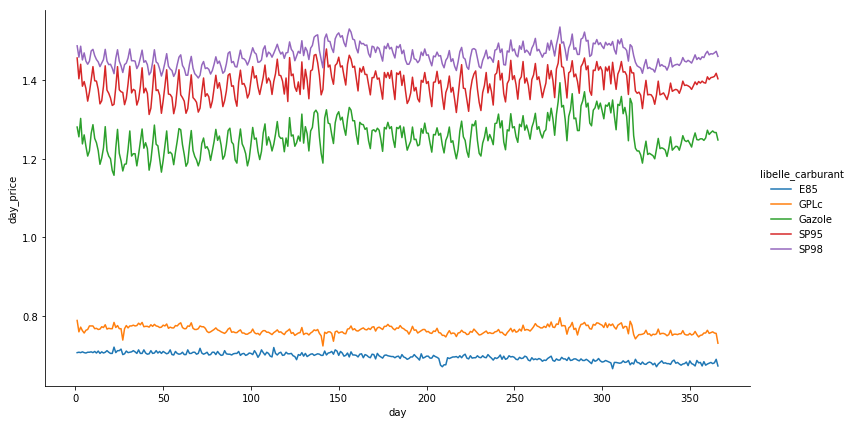

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

graph = sns.FacetGrid(day_price_df[~day_price_df.libelle_carburant.isin(['E10','GPlc'])].sort_values(by=['libelle_carburant', 'day']),
                      hue='libelle_carburant',
                       height=6,aspect=16/9)
graph.map(plt.plot, "day", "day_price")
graph.add_legend()

# Data Visualization(2/2)
### Représentation de l'indice de prix par carburant et par département.

Il n'a malheureusement pas été possible sur nos ordinateurs obsolètes d'exporter la table avec l'indice des prix par département sur Pandas. Cependant le code par la suite devrait permettre d'obtenir la représentation graphique demandée.
Les cartes apparaissent dans le browsers par défaut.

Exportation de table avec les departements et l'indice de prix sur pandas.


In [ ]:
indice_dep1=spark.sql(
    'SELECT id_station, prix_ddf.libelle_carburant, departement, dayofyear(date_releve) as day, 100*((avg(prix)-daydep_price.daydep_price) / daydep_price.daydep_price + 1) as indice '
    'FROM prix_ddf, daydep_price '
    'WHERE prix_ddf.libelle_carburant is not null '
        'and prix_ddf.libelle_carburant = daydep_price.libelle_carburant and dayofyear(date_releve) = daydep_price.day '
    'GROUP BY id_station, prix_ddf.libelle_carburant, dayofyear(date_releve), daydep_price.daydep_price, departement'
).toPandas()

Création d'une liste à partir de la table pandas pour le carburant E10

In [17]:
E10_df = indice_dep1.loc[indice_dep1['libelle_carburant'] == 'E10']

Création d'un dictionnaire qui associe le departement et l'indice de prix du carburant E10.

In [16]:
E10_d=E10_df.set_index('departement')['indice'].to_dict()

In [17]:
from IPython.display import SVG
import pygal
import lxml
from pygal.maps.fr import Departments

fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price E10 by department'
fr_chart.add('Average', E10_d)
fr_chart.render_in_browser()
svg(url='fr_chart.render()')

file://C:/Users/Rebecca/AppData/Local/Temp/tmp4_7ju05t.html


In [18]:
SP98_df=indice_dep1.loc[indice_dep1['libelle_carburant'] == 'SP98']
E85_df=indice_dep1.loc[indice_dep1['libelle_carburant'] == 'E85']
Gazole_df=indice_dep1.loc[indice_dep1['libelle_carburant'] == 'Gazole']
SP95_df=indice_dep1.loc[indice_dep1['libelle_carburant'] == 'SP95']
GPLc_df=indice_dep1.loc[indice_dep1['libelle_carburant'] == 'GPLc']

SP98_d=SP98_df.set_index('departement')['indice'].to_dict()
E85_d=E85_df.set_index('departement')['indice'].to_dict()
Gazole_d=Gazole_df.set_index('departement')['indice'].to_dict()
SP95_d=SP95_df.set_index('departement')['indice'].to_dict()
GPLc_d=GPLc_df.set_index('departement')['indice'].to_dict()


In [19]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price SP98 by department'
fr_chart.add('Average', SP98_d)
fr_chart.render_in_browser()
svg(url='fr_chart.render()')

file://C:/Users/Rebecca/AppData/Local/Temp/tmpt_5gja56.html


In [20]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price E85 by department'
fr_chart.add('Average', E85_d)
fr_chart.render_in_browser()
svg(url='fr_chart.render()')

file://C:/Users/Rebecca/AppData/Local/Temp/tmpcavfw_9o.html


In [21]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price Gazole by department'
fr_chart.add('Average', Gazole_d)
fr_chart.render_in_browser()
svg(url='fr_chart.render()')

file://C:/Users/Rebecca/AppData/Local/Temp/tmpmq22ycil.html


In [22]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price SP95 by department'
fr_chart.add('Average', SP95_d)
fr_chart.render_in_browser()

file://C:/Users/Rebecca/AppData/Local/Temp/tmpgqvrrrno.html


In [23]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price GPLc by department'
fr_chart.add('Average', GPLc_d)
fr_chart.render_in_browser()
svg(url='fr_chart.render()')

file://C:/Users/Rebecca/AppData/Local/Temp/tmp6_au37ki.html


### Représentation du prix moyen par carburant et par département.

On va représenter le prix moyen par carburant et par departement au lieu de l'indice de prix par departement. La table à convertir sous pandas est plus légère l'instruction fonctionne.
A executer seulement si le code précédent n'a pas marché.

In [ ]:
spark.sql(
    'SELECT *,SUBSTRING(code_postal, 0, 2) as departement '
    'FROM prix_ddf '
    ).cache().createOrReplaceTempView('departement_df')

On a crée une table avec les departements

In [ ]:
dep_price_df=spark.sql(
    'SELECT libelle_carburant, round(avg(prix), 3) as depart_price, departement '
    'FROM departement_df '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, departement'
).toPandas()

In [ ]:
E10_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'E10']
SP98_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'SP98']
E85_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'E85']
Gazole_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'Gazole']
SP95_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'SP95']
GPLc_df=dep_price_df.loc[dep_price_df['libelle_carburant'] == 'GPLc']

E10_d=E10_df.set_index('departement')['depart_price'].to_dict()
SP98_d=SP98_df.set_index('departement')['depart_price'].to_dict()
E85_d=E85_df.set_index('departement')['depart_price'].to_dict()
Gazole_d=Gazole_df.set_index('departement')['depart_price'].to_dict()
SP95_d=SP95_df.set_index('departement')['depart_price'].to_dict()
GPLc_d=GPLc_df.set_index('departement')['depart_price'].to_dict()

In [ ]:
from IPython.display import SVG
import pygal
import lxml
from pygal.maps.fr import Departments

fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price E10 by department'
fr_chart.add('Average', E10_d)
fr_chart.render_in_browser()

In [ ]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price SP98 by department'
fr_chart.add('Average', SP98_d)
fr_chart.render_in_browser()

In [ ]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price E85 by department'
fr_chart.add('Average', E85_d)
fr_chart.render_in_browser()

In [ ]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price Gazole by department'
fr_chart.add('Average', Gazole_d)
fr_chart.render_in_browser()

In [ ]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price SP95 by department'
fr_chart.add('Average', SP95_d)
fr_chart.render_in_browser()

In [ ]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Average price GPLc by department'
fr_chart.add('Average', GPLc_d)
fr_chart.render_in_browser()

# Modeling: Option 1

In [24]:
PYTHONIOENCODING="UTF-8"  

services_ddf=(spark.read.load('./Services2018.csv',
                              format='csv',sep='|',header='false',inferSchema='true')
             .selectExpr(
                 '_c0 as id_station',
                 '_c1 as code_postal',
                 '_c2 as type_station',
                 '_c3 as latitude',
                 '_c4 as longitude',
                 '_c5 as services'
            )
             .dropna(subset=['services'])
             .cache())

In [25]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.pipeline import Pipeline

tronconneuse = RegexTokenizer(inputCol='services',outputCol='liste_services',pattern=',')
#tronconneuse.transform(final_df1).show(5)
vectorizer= CountVectorizer(inputCol='liste_services',outputCol='vecteur_services',binary=True)
mon_pipeline=Pipeline(stages=[tronconneuse,vectorizer])
vecteur_services_ddf=mon_pipeline.fit(services_ddf).transform(services_ddf).cache().createOrReplaceTempView('vecteur_services')

In [26]:
mon_pipeline.fit(services_ddf).transform(services_ddf).show(5)

+----------+-----------+------------+-------------+-------------+--------------------+--------------------+--------------------+
|id_station|code_postal|type_station|     latitude|    longitude|            services|      liste_services|    vecteur_services|
+----------+-----------+------------+-------------+-------------+--------------------+--------------------+--------------------+
|   1000001|       1000|           R|    4620114.0|     519791.0|Station de gonfla...|[station de gonfl...|(28,[0,1,2,3],[1....|
|   1000002|       1000|           R|    4621842.0|     522767.0|Vente de gaz dome...|[vente de gaz dom...|(28,[0,1,2],[1.0,...|
|   1000004|       1000|           R|    4618800.0|     524500.0|Carburant additiv...|[carburant additi...|(28,[0,1,2,3,4,5,...|
|   1000005|       1000|           R|4620093.59235|519942.024022|Carburant additiv...|[carburant additi...|(28,[0,1,2,3,4,5,...|
|   1000006|       1000|           R|    4620754.0|     523758.0|Vente de gaz dome...|[vente de g

In [30]:
final_df =spark.sql('SELECT prix_table.id_station, prix_table.code_postal,prix_table.type_station,prix_table.Lat,prix_table.Long,prix_table.type_carburant,prix_table.libelle_carburant,prix_table.date_releve,year,month,week,prix, vecteur_services, dayofyear(date_releve) as day '
         'FROM prix_table, vecteur_services '
         'WHERE prix_table.id_station=vecteur_services.id_station ').cache()

essai regression 1 OLS

In [31]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['id_station', 'Long', 'Lat', 'type_carburant', 'day', 'vecteur_services'], outputCol = 'features')
vfinal_df = vectorAssembler.transform(final_df)
vfinal_df = vfinal_df.select(['features', 'prix'])
vfinal_df.show(3)

+--------------------+-----+
|            features| prix|
+--------------------+-----+
|(33,[0,1,2,3,4,5,...|1.376|
|(33,[0,1,2,3,4,5,...|1.389|
|(33,[0,1,2,3,4,5,...|1.376|
+--------------------+-----+
only showing top 3 rows



In [32]:
splits = vfinal_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]
vfinal_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- prix: double (nullable = true)



In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol='prix')
lr_model = lr.fit(train_df.selectExpr('features','prix'))
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

ESSAI prediction 2 random forest

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labelIndexer = StringIndexer(inputCol="prix", outputCol="indexedLabel").fit(vfinal_df)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
#featureIndexer = VectorIndexer(inputCol=['id_station', 'Long', 'Lat', 'type_carburant', 'day', 'vecteur_services'], outputCol="indexedFeatures").fit(vfinal_df)
    
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = vfinal_df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, rf, labelConverter])

In [ ]:
model=pipeline.fit(trainingData)